In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib
import os
from scipy.stats import shapiro, ttest_ind, mannwhitneyu, t
import warnings 
warnings.simplefilter('ignore')


# Задача: понять значимо ли различаются интересующие нас метрики у контрольной и тестовой модели рекомендаций

## Метрики, которые нам интересны :
* #### Hitrate
* #### Число лайков на пользователя

## Методы, которые будем использовать
* #### __T-test__ - _для проверки гипотезы по хитрейту_
* #### __Критерий Манна-Уитни-Уилкоксона__ - _для проверки гипотезы по второй метрике_

### В обоих случаях пороговая вероятность ошибки первого рода = 0.05


In [3]:
os.chdir('logs')
likes_df = pd.read_csv('likes.csv')
likes_df.rename(columns={'timestamp': 'like_timestamp'}, inplace=True)


likes_df.head()

,user_id,post_id,like_timestamp
0,128381,4704,1654030804
1,146885,1399,1654030816
2,50948,2315,1654030828
3,14661,673,1654030831
4,37703,1588,1654030833


In [4]:
views_df = pd.read_csv('views.csv')
views_df.rename(columns={'timestamp': 'view_timestamp'}, inplace=True)

os.chdir('..')

views_df.head()

,user_id,exp_group,recommendations,view_timestamp
0,128381,control,[3644 4529 4704 5294 4808],1654030803
1,146885,test,[1399 1076 797 7015 5942],1654030811
2,50948,test,[2315 3037 1861 6567 4093],1654030825
3,37703,test,[2842 1949 162 1588 6794],1654030826
4,14661,test,[2395 5881 5648 3417 673],1654030829


In [5]:
# нужно правильно подтянуть лайки к показам, изначально нет информации какой показ к какому лайну относится 
merge_df = views_df.merge(likes_df, on='user_id', how='outer')
merge_df['post_id'] = merge_df['post_id'].fillna(-1).astype(int)

# рекомендованные посты выгружаются в формате строки, преобразуем их в список
def to_list(rec_string):
    rec_string = rec_string.replace('[', '').replace(']', '')
    
    split_rec_str = rec_string.split()
    
    return [int(post_id) for post_id in split_rec_str]

merge_df['recommendations'] = merge_df['recommendations'].apply(to_list)

merge_df.head()

,user_id,exp_group,recommendations,view_timestamp,post_id,like_timestamp
0,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,4704,1.654031e+09
1,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,5294,1.654031e+09
2,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,3608,1.655049e+09
3,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,2542,1.655049e+09
4,128381,control,"[3644, 4529, 4704, 5294, 4808]",1654030803,4165,1.655053e+09


### Считаем Hitrate

In [6]:
hitrate_list = []

one_hour = 60 * 60

'''
Пояснение:
Будем считать, что хитрейт принимет значение 1, если в течении часа 
пользователь лайкнул хотя-бы один пост,
который был в числе рекомендованных
'''

# по всем юзерам
for usr_id in merge_df.user_id.unique():
    
    user_actions = merge_df[merge_df['user_id'] == usr_id]

    # пробегаемся по всем рекомендациям для этого юзера
    for rec_time in user_actions.view_timestamp.unique():
        # список рекомендованных постов
        
        recomended_posts = user_actions.loc[user_actions['view_timestamp'] == rec_time]['recommendations'].head(1).values[0]
        # разница между времененм лайка и временем рекомендации
        diff_time = user_actions.like_timestamp - rec_time
        
        # создаем условия
        time_diff_less_one_hour = (diff_time >= 0) & (diff_time <= one_hour)
        
        # проверяем рекомендовали мы лайкнутый пост или нет 
        is_post_recomended = user_actions.post_id.isin(recomended_posts)

        # считаем сколько строк удовлетворяет условиям
        result = user_actions[time_diff_less_one_hour & is_post_recomended].shape[0]
        
        hitrate_list.append([usr_id, rec_time, int(result > 0)])


In [7]:
hitrate_df = pd.DataFrame(data=hitrate_list,
                          columns=['user_id', 'view_timestamp', 'hitrate'])

views_df = views_df.merge(hitrate_df, on=['user_id', 'view_timestamp'], how='inner')

views_df.head()

,user_id,exp_group,recommendations,view_timestamp,hitrate
0,128381,control,[3644 4529 4704 5294 4808],1654030803,1
1,146885,test,[1399 1076 797 7015 5942],1654030811,1
2,50948,test,[2315 3037 1861 6567 4093],1654030825,1
3,37703,test,[2842 1949 162 1588 6794],1654030826,1
4,14661,test,[2395 5881 5648 3417 673],1654030829,1


### Посчитаем метрики используя бакетирование

In [8]:
views_df['user_id'].values

def md5_bucket_partition(user_id):
    # переводим строку в байты
    encoded_id = str(user_id).encode()
    
    # применяем хэш-функцию
    hashed_id = hashlib.md5(encoded_id)
    
    # приводим к целочисленоному типу и уменьшаем порядок % 100
    return int(hashed_id.hexdigest(), 16) % 100


views_df['bucket'] = views_df['user_id'].apply(md5_bucket_partition)

control_sample = views_df[views_df['exp_group'] == 'control']

test_sample = views_df[views_df['exp_group'] == 'test'].reset_index(drop=True)

In [9]:
control_sample

,user_id,exp_group,recommendations,view_timestamp,hitrate,bucket
0,128381,control,[3644 4529 4704 5294 4808],1654030803,1,64
10,155358,control,[4889 3374 1344 6754 2419],1654030871,0,10
11,157618,control,[2529 1755 5769 992 1326],1654030872,0,30
13,20451,control,[4940 1264 4497 1416 5421],1654030877,1,58
14,147602,control,[2839 1537 2696 4613 2811],1654030880,1,14
...,...,...,...,...,...,...
193284,43854,control,[4916 2356 4721 1201 4194],1655240314,1,22
193285,3615,control,[1578 6326 906 2833 993],1655240322,1,20
193289,18833,control,[1367 7074 5344 6597 5120],1655240338,0,97
193291,63527,control,[2454 191 3873 6404 1588],1655240347,1,74


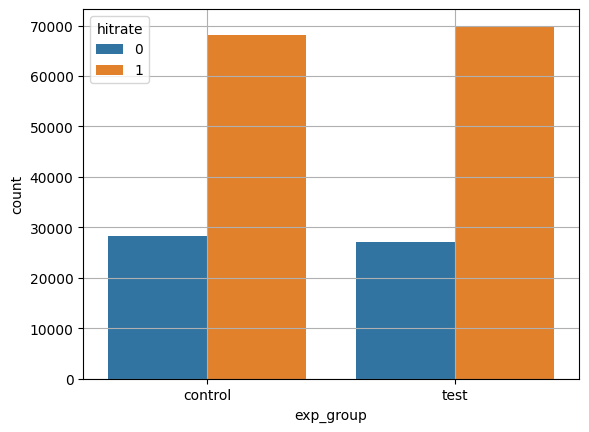

In [10]:
sns.countplot(x='exp_group', hue='hitrate', data=views_df)
plt.grid()


In [11]:
control_hitrate = control_sample.groupby('bucket')['hitrate'].mean().values

test_hitrate = test_sample.groupby('bucket')['hitrate'].mean().values

print(f'Вероятность получить такое распределение средних, если в гс они распределены нормально :\nВ контрольной выборке - {round(shapiro(control_hitrate)[1],4)}\nВ тестовой выборке : {round(shapiro(test_hitrate)[1],4)}')


Вероятность получить такое распределение средних, если в гс они распределены нормально :
В контрольной выборке - 0.5621
В тестовой выборке : 0.6237


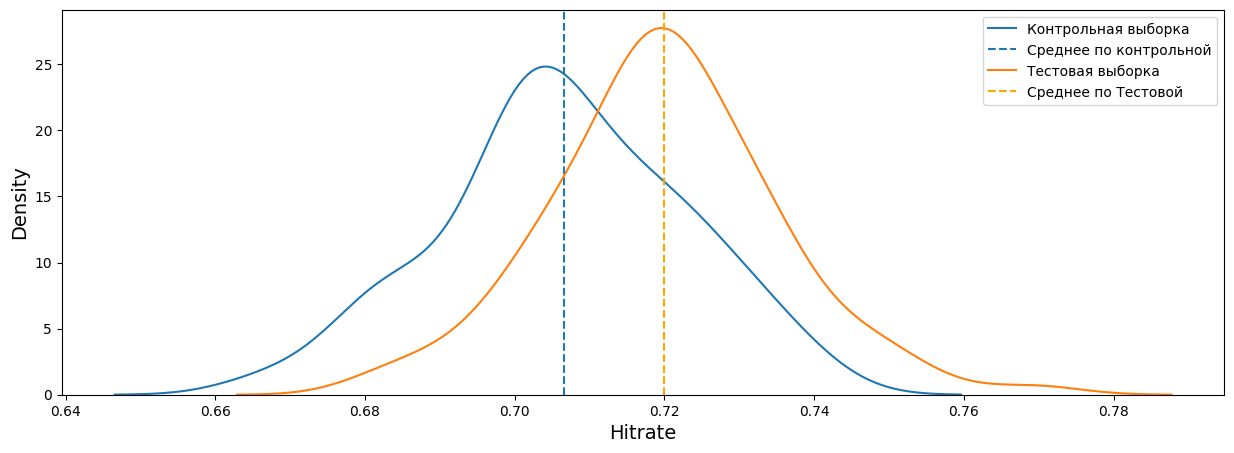

In [12]:
fig = plt.figure()

fig.set_size_inches((15,5))
sns.kdeplot(control_hitrate, label='Контрольная выборка')
plt.axvline(control_hitrate.mean(), linestyle='--', label='Среднее по контрольной')

sns.kdeplot(test_hitrate, label='Тестовая выборка')
plt.axvline(test_hitrate.mean(), c='orange', linestyle='--', label='Среднее по Тестовой')

plt.xlabel('Hitrate', size=14)
plt.ylabel('Density', size=14)

plt.legend()
plt.show()

### Распределение метрики близко к нормальному, поэтому без опасений применяем  T-test и получим вероятность того, что среднее значение Hitrate в контрольной выборке меньше чем в тестовой

In [13]:
ttest_results = np.array(ttest_ind(control_hitrate, test_hitrate, alternative='less')).round(5)

print(f'statistic: {ttest_results[0]}')
print(f'p-value: {ttest_results[1]}')

statistic: -6.00619
p-value: 0.0


### Теперь посчитаем числолайков на пользователя

In [27]:
merge_df['bucket'] = merge_df['user_id'].apply(md5_bucket_partition)


control_like_counts = merge_df[merge_df['exp_group'] == 'control'].groupby('bucket')['like_timestamp'].count()

test_like_counts = merge_df[merge_df['exp_group'] == 'test'].groupby('bucket')['like_timestamp'].count()


print(f'Тест Шапиро: \nКонтрольная {shapiro(control_like_means)[1]}\nТестовая {shapiro(test_like_means)[1]}')


Тест Шапиро: 
Контрольная 0.8587700724601746
Тестовая 0.02414591982960701


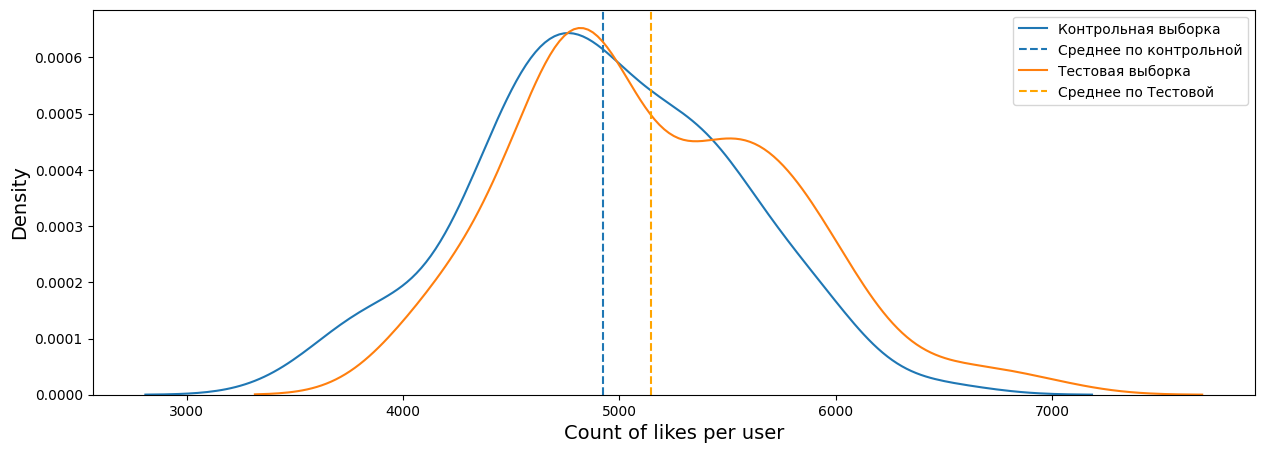

In [29]:
fig = plt.figure()

fig.set_size_inches((15,5))
sns.kdeplot(control_like_counts, label='Контрольная выборка')
plt.axvline(control_like_counts.mean(), linestyle='--', label='Среднее по контрольной')

sns.kdeplot(test_like_counts, label='Тестовая выборка')
plt.axvline(test_like_counts.mean(), c='orange', linestyle='--', label='Среднее по Тестовой')

plt.xlabel('Count of likes per user', size=14)
plt.ylabel('Density', size=14)

plt.legend()
plt.show()

### Распределение метрики в тестовой выборке не нормально, в такой ситуации уместнее применить Критерий Манна-Уитни-Уилкоксона

In [11]:
mannwhitneyu_results = np.array(mannwhitneyu(control_like_means, test_like_means, alternative='less')).round(5)


print(f'statistic: {mannwhitneyu_results[0]}')
print(f'p-value: {mannwhitneyu_results[1]}')

statistic: 4092.5
p-value: 0.01334


## Выводы:
* ### Hitrate в тестовой и контрольной выборке стат значимо различается, в тесте метрика подросла
* ### Число лайков на пользователя в выборках тоже значимо различаются, в тесте метрика подросла